In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
#
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.ticker as ticker
# from collections import namedtuple

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here


In [2]:
def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """

    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

In [3]:
methods=['scalar', 'avx2', 'avx512512', 'avx512256']

rx_dict = {
    'build': re.compile(r'(Generation|Cuckoo Table Generation:) (?P<build>.*) ms \n'),
    'probe': re.compile(r'Join core: (?P<probe>\d*) ms \n'),
}

data = []
build = None
probe = None
        
for m in methods:
    for i in range(10, 100, 10):
        with open('/home/flav/Mestrado/MHaJoL/data/out/joins/_'+str(i)+'/'+m+'.out', 'r') as file_object:
            line = file_object.readline()
            while line:
                # at each line check for a match with a regex
                key, match = _parse_line(line)
                
                # extract build time
                if key == 'build':
                    build = match.group('build')
                    build = int(build)

                # extract probe time
                if key == 'probe':
                    probe = match.group('probe')
                    probe = int(probe)

                if (build is not None and probe is not None):
                    # create a dictionary containing this row of data
                    row = {
                        'buildTime': build,
                        'probeTime': probe,
                        'method': m,
                        'selectivity': i
                    }
                    # append the dictionary to the data list
                    data.append(row)
                line = file_object.readline()

            # create a pandas DataFrame from the list of dicts
            df = pd.DataFrame(data)
            # set the School, Grade, and Student number as the index
#             df.set_index(['buildTime', 'probeTime', 'method', 'selectivity'], inplace=True)
#             # consolidate df to remove nans
#             df = df.groupby(level=df.index.names).first()
#             # upgrade Score from float to integer
#             df = df.apply(pd.to_numeric, errors='ignore')
print(df.head(100))


    buildTime  method  probeTime  selectivity
0         197  scalar         21           10
1         197  scalar         21           10
2         197  scalar         21           10
3         197  scalar         21           10
4         197  scalar         21           10
5         197  scalar         21           10
6         197  scalar         21           10
7         197  scalar         21           10
8         197  scalar         21           10
9         197  scalar         21           10
10        197  scalar         21           10
11        197  scalar         21           10
12        197  scalar         21           10
13        197  scalar         21           10
14        197  scalar         21           10
15        197  scalar         21           10
16        197  scalar         21           10
17        197  scalar         21           10
18        197  scalar         21           10
19        197  scalar         21           10
20        197  scalar         21  

In [4]:
dfQuantile1 = df.groupby(['method', 'selectivity']).quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile1 = dfQuantile1.rename(index=str, columns={"buildTime": "first"})
dfQuantile1 = dfQuantile1.drop(columns=['probeTime'])

dfQuantile2 = df.groupby(['method', 'selectivity']).quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile2 = dfQuantile2.rename(index=str, columns={"buildTime": "third"}).drop(columns=['probeTime'])

dfQuantile = pd.merge(dfQuantile1, dfQuantile2, how='inner', on=['method', 'selectivity'])
dfQuantile['IQR'] = dfQuantile['third'] - dfQuantile['first']

dfAggMedian = df.groupby(['method', 'selectivity'], as_index = False).aggregate(np.median)
dfAggMedian = dfAggMedian.rename(index=str, columns={"buildTime": "median"}).drop(columns=['probeTime'])
dfIQR = pd.merge(dfQuantile, dfAggMedian, how='inner', on=['method', 'selectivity'])
dfIQR = pd.merge(dfIQR, df, how='inner', on=['method', 'selectivity']).drop(columns=['probeTime'])

dfIQR['calc1'] = dfIQR['first'] - (1.5 * dfIQR['IQR'])
dfIQR['calc2'] = dfIQR['third'] - (1.5 * dfIQR['IQR'])

dfIQR['values'] = np.where((dfIQR['buildTime'] < (dfIQR['first'] - (0.5 * dfIQR['IQR']))) | (dfIQR['buildTime'] < (dfIQR['third'] - (0.5 * dfIQR['IQR']))), dfIQR['median'], dfIQR['buildTime'])

dfIQR = dfIQR.drop(columns=['buildTime', 'first', 'third', 'IQR', 'median', 'calc1', 'calc2'])
dfIQR = dfIQR.rename(index=str, columns={"values": "value"})

dfAggAVG = dfIQR.groupby(['method', 'selectivity'], as_index = False).aggregate(['mean','std'])


dfAggAVG.head(100)

value          
                             mean       std
method    selectivity                      
avx2      10            22.812067  2.782991
          20            21.024636  0.210690
          30            21.035513  0.282503
          40            20.332404  0.512391
          50            20.109515  0.398369
          60            20.026170  0.204342
          70            20.068610  0.328873
          80            20.002045  0.045179
          90            20.000000  0.000000
avx512256 10            19.733024  1.949799
          20            18.170189  0.619267
          30            18.151675  0.515232
          40            18.156660  0.701081
          50            18.138965  0.759934
          60            18.110105  0.499100
          70            18.159235  0.715608
          80            18.163799  0.696513
          90            17.345318  0.840305
avx512512 10            20.113826  0.562541
          20            19.110503  0.413574
          30            19.127730  0.553998
          40            19.062566  0.295233
          50            18.285069  0.636557
          60            18.218313  0.501549
          70            18.175362  0.458885
          80            18.206399  0.591475
          90            17.295251  0.518279
scalar    10           195.823953  3.857966
          20           194.283064  2.795231
          30           193.259340  6.640119
          40           190.689163  3.878580
          50           189.765033  4.686616
          60           186.580616  3.227628
          70           184.648546  3.734018
          80           181.041027  5.721900
          90           172.549252  3.860180

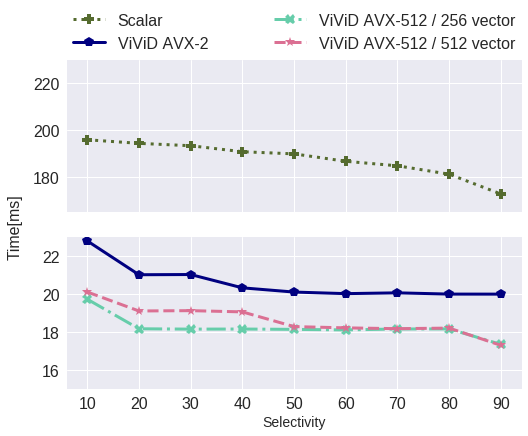

In [12]:
#X axis
n_groups = 9
index = np.arange(n_groups)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

# NP arrays of values
dfMethodVec = dfAggAVG.xs("avx2", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVec = dfMethodVec["mean"]

dfMethod = dfAggAVG.xs("scalar", level='method')['value'].reset_index().sort_values('selectivity')
dfValues = dfMethod["mean"]

dfMethodVi = dfAggAVG.xs("avx512512", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi = dfMethodVi["mean"]

dfMethodVi2 = dfAggAVG.xs("avx512256", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi2 = dfMethodVi2["mean"]

#Style configs
plt.style.use('seaborn')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# fig, ax = plt.subplots()
# ax.grid(alpha=0.4)
# ax2.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

#Plot
ax.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

ax2.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

#Axis and labels
ax2.set_xlabel('Selectivity', fontsize=14)
ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.,fancybox=True, fontsize=16)
fig.text(0.1, 0.5, 'Time[ms]', ha='center', va='center', rotation='vertical', fontsize=16)

#Break the y axis
ax.set_ylim(165, 230)  # outliers only
ax2.set_ylim(15, 23)  # most of the data

# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.rcParams.update({'font.size': 16})

#Draw and save
plt.show()
fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/time.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight')
fig.clf()


In [6]:
#milion tuples per second

dfIQR['seconds']=dfIQR['value']/1000
dfIQR['tuplesPerSecond']=1500000/dfIQR['seconds']
dfIQR['Mtps']=1.5/dfIQR['seconds']

dfIQR=dfIQR.drop(columns=['seconds', 'tuplesPerSecond', 'value']).rename(index=str, columns={"Mtps": "value"})

dfAggAVGM = dfIQR.groupby(['method', 'selectivity'], as_index = False).aggregate(['mean','std'])

dfAggAVGM.head(100)

value          
                            mean       std
method    selectivity                     
avx2      10           66.202563  4.628031
          20           71.351458  0.657169
          30           71.319459  0.855442
          40           73.819181  1.799507
          50           74.618473  1.360431
          60           74.909176  0.704421
          70           74.762149  1.132576
          80           74.992695  0.161353
          90           75.000000  0.000000
avx512256 10           76.585186  5.800650
          20           82.635220  2.425368
          30           82.697087  2.118671
          40           82.714002  2.591234
          50           82.808884  2.726147
          60           82.880384  1.954986
          70           82.707389  2.665341
          80           82.682204  2.626925
          90           86.650861  3.573523
avx512512 10           74.624424  1.756933
          20           78.524535  1.556716
          30           78.477781  1.990745
          40           78.705757  1.130558
          50           82.124371  2.597336
          60           82.393176  2.124650
          70           82.578283  1.941759
          80           82.467850  2.440777
          90           86.803288  2.480623
scalar    10            7.662690  0.139675
          20            7.722198  0.104674
          30            7.769204  0.222080
          40            7.869135  0.144375
          50            7.908753  0.172313
          60            8.041677  0.130575
          70            8.126557  0.149523
          80            8.292382  0.221469
          90            8.697052  0.173790

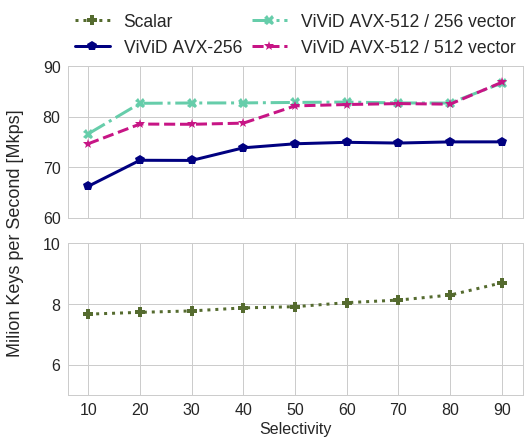

In [14]:
#X axis
n_groups = 9
index = np.arange(n_groups)

# NP arrays of values
dfMethodVec = dfAggAVGM.xs("avx2", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVec = dfMethodVec["mean"]

dfMethod = dfAggAVGM.xs("scalar", level='method')['value'].reset_index().sort_values('selectivity')
dfValues = dfMethod["mean"]

dfMethodVi = dfAggAVGM.xs("avx512512", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi = dfMethodVi["mean"]

dfMethodVi2 = dfAggAVGM.xs("avx512256", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi2 = dfMethodVi2["mean"]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

plt.style.use('seaborn-whitegrid')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

# fig, ax = plt.subplots()
# ax.grid(alpha=0.4)
# ax2.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

#Plot
ax.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-256', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi, color='mediumvioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

ax2.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-256', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi, color='mediumvioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

#Axis and labels
ax2.set_xlabel('Selectivity', fontsize=16)
ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.,fancybox=True, fontsize=17.5)
fig.text(0.1, 0.5, 'Milion Keys per Second [Mkps]', ha='center', va='center', rotation='vertical', fontsize=18)

#Break the y axis
ax.set_ylim(60, 90)  # outliers only
ax2.set_ylim(5, 10)  # most of the data

# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.rcParams.update({'font.size': 18})

#Draw and save
plt.show()
fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/mtps.pdf', format='pdf', facecolor='white', edgecolor='none',  bbox_inches='tight')
fig.clf()